In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import networkx as nx
from community import community_louvain

import pycountry
import seaborn as sns

import collections
import jellyfish

import bs4 as bs  
import urllib.request  
import re  
import nltk

#from py_translator import Translator
from googletrans import Translator
from gensim.models import Word2Vec

# Importing the notebook with all the methods definition
import importlib
import GKG

import copy
import simplejson as json

In [5]:
importlib.reload(GKG)

<module 'GKG' from '/Users/aminmekacher/Documents/EPFL Master/MA2/GDELT Project/GDELT-Project/Notebooks/GKG.py'>

In [2]:
# Defining a list of themes of interest, to construct a more narrowed graph

themes_of_interest = ['ALLIANCE', 'BORDER', 'CHARASMATIC_LEADERSHIP', 'CLAIM_CREDIT', 'CORRUPTION', 'DEMOCRACY',
                      'ECON_DEREGULATION', 'ELECTION', 'ELECTION_FRAUD', 'EXTREMISM', 'FREESPEECH', 'GENERAL_GOVERNMENT',
                      'GOV_DISSOLVEGOV', 'GOV_DIVISIONOFPOWER', 'GOV_REFORM', 'HATE_SPEECH', 'IDEOLOGY', 'IMPEACHMENT', 
                      'INFO_HOAX', 'INFO_RUMOR', 'INTERNET_CENSORSHIP', 'JIHAD', 'LEADER', 'LEGISLATION', 'MEDIA_CENSORSHIP',
                      'MEDIA_MSM', 'MEDIA_SOCIAL', 'PERSECUTION', 'POLITICAL_PRISONER', 'PROPAGANDA', 'PROTEST', 'REBELS',
                      'RELIGION', 'SCANDAL', 'SELF_IDENTIFIED_HUMAN_RIGHTS', 'SEPARATISTS', 'SLFID_DICTATORSHIP',
                      'SOC_SUSPICIOUSPEOPLE', 'TAX_RELIGION', 'TAX_TERROR_GROUP', 'TERROR', 'TOURISM', 'TREASON', 
                      'UNREST_POLICEBRUTALITY']

In [3]:
# Analysis of the Tunisia Country and Tunisia Actors dataframes

tunisia_country = pd.read_csv('../CSV Files/tunisia_country.csv', sep='\t', delimiter='\t', decimal = '.', error_bad_lines=False, 
                                  engine='c', encoding='latin-1')

tunisia_actor = pd.read_csv('../CSV Files/tunisia_actors.csv', sep='\t', delimiter='\t', decimal = '.', error_bad_lines=False, 
                                  engine='c', encoding='latin-1')

/Users/aminmekacher/miniconda3/envs/gdelt_project/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
# Extraction of the themes mentioned in the Tunisia Actor dataframe
theme_list = GKG.theme_list_extraction(tunisia_actor)

Goal: create a graph with each mentioned actor connected between each other if they are named in the same articles

In [6]:
tf_score, idf_score, tf_idf = GKG.tf_idf_computation(dataframe=tunisia_actor, themes_of_interest=themes_of_interest)

In [12]:
tf_total, idf_total, tf_idf_total = GKG.tf_idf_computation(dataframe=tunisia_actor, themes_of_interest=theme_list)

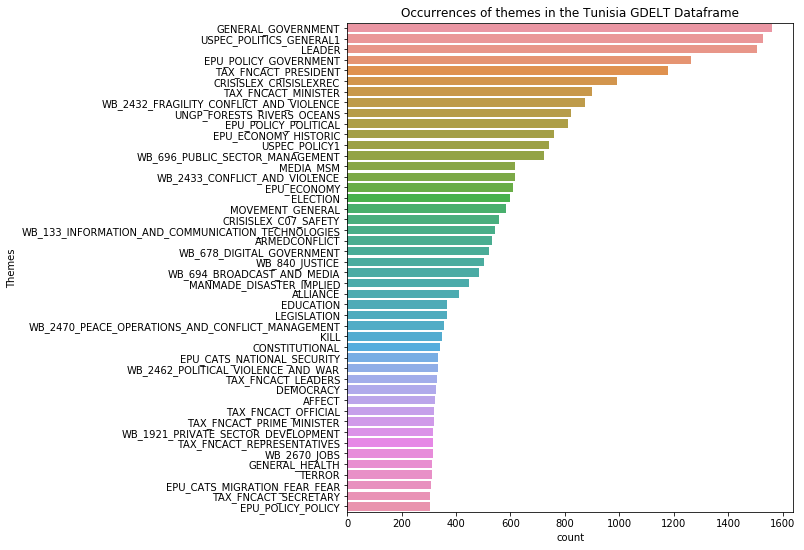

In [8]:
# Cleaning the idf dictionary to keep only the most common themes in the news
idf_total_clean = pd.DataFrame(columns=['theme'])
count = 0
for key, value in idf_total.items():
    if value > 300:
        for count_theme in range(0, value):
            idf_total_clean.loc[count]= key
            count += 1
            
descending_order = idf_total_clean['theme'].value_counts().sort_values(ascending=False).index

plt.figure(figsize=(8,9))
g = sns.countplot(y=idf_total_clean['theme'], order=descending_order)
g.set_ylabel('Themes')
g.set_title('Occurrences of themes in the Tunisia GDELT Dataframe')
plt.show()

In [ ]:
import random

dict_ocurrences = GKG.media_coverage_visualization(tunisia_country)

number_donuts = len(dict_ocurrences)
media_names = []
media_values = []
num_entries = []
donuts_color = []

#my_circle = [, plt.Circle((0,0), 0.7, color='white'), plt.Circle((0,0), 0.7, color='white')]

for index_donut in range(0, number_donuts):
    day_dict = dict_ocurrences[index_donut]
    
    filtered_day_dict = {k:v for k,v in day_dict.items() if v > 25}
    
    media_names.append(list(filtered_day_dict.keys()))
    media_values.append(list(filtered_day_dict.values()))
    
    num_entries.append(len(media_names))
    
    # Generating random colors for the plot
    
    r = np.mod(random.sample(range(0, 510), len(media_names[index_donut])), 255) / 256
    g = np.mod(random.sample(range(0, 510), len(media_names[index_donut])), 255) / 256
    b = np.mod(random.sample(range(0, 510), len(media_names[index_donut])), 255) / 256

    random_color = []
    for color_index in range(0, r.shape[0]):
        random_color.append((r[color_index], g[color_index], b[color_index]))
    
    donuts_color.append(random_color)

my_circle = [plt.Circle((0,0), 0.7, color='white'), plt.Circle((0,0), 0.7, color='white'),
             plt.Circle((0,0), 0.7, color='white'), plt.Circle((0,0), 0.7, color='white'),
             plt.Circle((0,0), 0.7, color='white'), plt.Circle((0,0), 0.7, color='white')]

for index_plot in range(1, len(donuts_color)):
    plt.subplot(2, 3, index_plot)
    plt.subplots_adjust(wspace=1)
    plt.pie(media_values[index_plot], labels=media_names[index_plot], colors=donuts_color[index_plot])
    p = plt.gcf()
    p.gca().add_artist(my_circle[index_plot - 1])
    
    

In [ ]:
# Analysis of the GCAM dimensions occurences for the tunisia_actor dataframe. Post-processing to keep only the top-k dimensions

gcam_dict = GKG.gcam_extraction(tunisia_actor, threshold=0.05)
sorted_gcam_dict = {r: gcam_dict[r] for r in sorted(gcam_dict, key=gcam_dict.get, reverse=True)}

topk_dict = GKG.topk_dict_extraction(sorted_gcam_dict, k=20)

In [6]:
# Actor network creation
G_actor = nx.Graph()
GKG.social_graph_creation(G_actor, tunisia_actor)

list_actor = list(G_actor.nodes)
nodes_actor = len(list(G_actor.nodes))
edges_actor = len(list(G_actor.edges))
print("--- Tunisia Actor ---")
print("A total of %d actors have been detected" % nodes_actor)
print("A total of %d edges have been drawn" % edges_actor)

# Adding attribute to the actors of interest
actors_of_interest = {'Baji Essebsi': 'Nidaa Tounes', 'Beji Essebssi': 'Nidaa Tounes', 'Baji Kaid Essebsi': 'Nidaa Tounes',
                      'Hafedh Essebssi': 'Nidaa Tounes', 'Hafez Essebsi': 'Nidaa Tounes', 'Youssef Chahed': 'Nidaa Tounes', 
                      'Ridha Belhadj': 'Nidaa Tounes', 'Selim Azzabi': 'Nidaa Tounes', 'Salma Elloumi': 'Nidaa Tounes',
                      'Mohsen Marzouk': 'Nidaa Tounes', 'Khemaies Jhinaoui': 'Nidaa Tounes', 'Rashid Ghannouchi': 'Ennahda',
                      'Abdelkarim Harouni': 'Ennahda', 'Nourredine Khadmi': 'Ennahda', 'Hammadi Jabali': 'Ennahda',
                      'Ghazi Jeribi': 'Independent', 'Mariem Belkadhi': 'Journalist'}
    
for actor, affiliation in actors_of_interest.items():
    G_actor.node[actor]['affiliation'] = affiliation

--- Tunisia Actor ---
A total of 1816 actors have been detected
A total of 47407 edges have been drawn


List:  47407


/Users/aminmekacher/miniconda3/envs/gdelt_project/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Distribution of the edge weight for the Tunisia actor network')

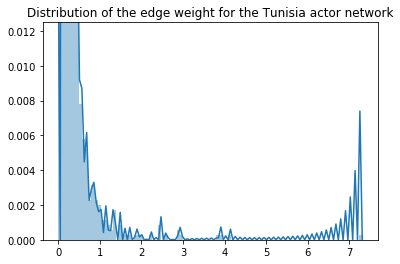

In [7]:
# Display of a histogram showing the distribution of the edge weight in the actor graph

edges_weight = nx.get_edge_attributes(G_actor, 'weight')
weight_list = []

for actor_edge in G_actor.edges:
    weight_list.append(edges_weight[actor_edge])
    
print("List: ", len(weight_list))
sns.distplot(weight_list, bins=100)
plt.ylim(0, 0.0125)
#plt.xlim(0, 0.72)
plt.title("Distribution of the edge weight for the Tunisia actor network")

In [8]:
# Definition of an actor network with weak edges (weight < 0.72) removed

threshold_high = 0.72
G_actor_threshold_high = copy.deepcopy(G_actor)
G_actor_threshold_high = GKG.network_edge_filtering(graph=G_actor_threshold_high, threshold=threshold_high)

filepath_threshold_high = '../Gephi Files/tunisia_threshold_high.gexf'
nx.write_gexf(G_actor_threshold_high, filepath_threshold_high, version='1.2draft')

threshold_low = 0.2
G_actor_threshold_low = copy.deepcopy(G_actor)
G_actor_threshold_low = GKG.network_edge_filtering(graph=G_actor_threshold_low, threshold=threshold_low)

filepath_threshold_low = '../Gephi Files/tunisia_threshold_low.gexf'
nx.write_gexf(G_actor_threshold_low, filepath_threshold_low, version='1.2draft')

Removed edge:  47332
Removed nodes:  1760
Removed edge:  46610
Removed nodes:  1364


In [9]:
# Computation of the page rank for each actor. This value is then assigned as an attribute

pagerank_actor = nx.algorithms.link_analysis.pagerank_alg.pagerank(G_actor)
        
for actor in list(G_actor.nodes):
    G_actor.node[actor]['pageRank'] = float(pagerank_actor[actor])
    
pagerank_high = nx.algorithms.link_analysis.pagerank_alg.pagerank(G_actor_threshold_high)
        
for actor in list(G_actor_threshold_high.nodes):
    G_actor_threshold_high.node[actor]['pageRank'] = float(pagerank_high[actor])
    
pagerank_low = nx.algorithms.link_analysis.pagerank_alg.pagerank(G_actor_threshold_low)
        
for actor in list(G_actor_threshold_low.nodes):
    G_actor_threshold_low.node[actor]['pageRank'] = float(pagerank_low[actor])

In [10]:
# By using the PageRank attribute, we can extract the 10 most influential actors in the network

actor_dict = dict(G_actor.nodes)
sorted_actor_dict = dict(sorted(actor_dict.items(), key = lambda x: x[1]['pageRank'], reverse=True))

topk_actor = GKG.topk_actor_extraction(sorted_actor_dict, k=10)

# High Threshold

actor_dict_high = dict(G_actor_threshold_high.nodes)
sorted_actor_dict_high = dict(sorted(actor_dict_high.items(), key = lambda x: x[1]['pageRank'], reverse=True))

topk_actor_high = GKG.topk_actor_extraction(sorted_actor_dict_high, k=10)

# Low Threshold

actor_dict_low = dict(G_actor_threshold_low.nodes)
sorted_actor_dict_low = dict(sorted(actor_dict_low.items(), key = lambda x: x[1]['pageRank'], reverse=True))

topk_actor_low = GKG.topk_actor_extraction(sorted_actor_dict_low, k=10)

In [11]:
# Study of the cliques in the actor social network

partition = community_louvain.best_partition(G_actor)
for node_actor in list(G_actor.nodes):
    G_actor.node[node_actor]['community'] = partition[node_actor]

filepath_actor = '../Gephi Files/tunisia_actor.gexf'
nx.write_gexf(G_actor, filepath_actor, version="1.2draft")

# High threshold

partition_high = community_louvain.best_partition(G_actor_threshold_high)
for node_actor in list(G_actor_threshold_high.nodes):
    G_actor_threshold_high.node[node_actor]['community'] = partition_high[node_actor]

filepath_actor_high = '../Gephi Files/tunisia_threshold_high.gexf'
nx.write_gexf(G_actor_threshold_high, filepath_actor_high, version="1.2draft")

# Low threshold

partition_low = community_louvain.best_partition(G_actor_threshold_low)
for node_actor in list(G_actor_threshold_low.nodes):
    G_actor_threshold_low.node[node_actor]['community'] = partition_low[node_actor]

filepath_actor_low = '../Gephi Files/tunisia_threshold_low.gexf'
nx.write_gexf(G_actor_threshold_low, filepath_actor_low, version="1.2draft")

In [12]:
GKG.save_to_json(G=G_actor_threshold_high, fname='../JSON_files/tunisia_actor_threshold_high')
GKG.save_to_json(G=G_actor_threshold_low, fname='../JSON_files/tunisia_actor_threshold_low')

In [32]:
G_actor = GKG.load_json(fname='../JSON_files/tunisia_actor_threshold_low')
list_actor = list(G_actor.nodes)
importlib.reload(GKG)

<module 'GKG' from '/Users/aminmekacher/Documents/EPFL Master/MA2/GDELT Project/GDELT-Project/Notebooks/GKG.py'>

In [33]:
# Theme network generation

G_themes = nx.Graph()
G_themes = nx.create_empty_copy(G_actor)
list_actor = list(G_themes.nodes)
GKG.theme_network_creation(G_themes, list_actor, tunisia_actor, themes_of_interest, tf_idf_total)

for theme in themes_of_interest:
    if G_themes.has_node(theme):
        G_themes.node[theme]['nodeType'] = 'Theme'
    
for node in list(G_themes.nodes):
    if node not in themes_of_interest:
        G_themes.node[node]['nodeType'] = 'Actor'

filepath_theme = '../Gephi Files/tunisia_themes_low.gexf'
nx.write_gexf(G_themes, filepath_theme, version='1.2draft')

In [34]:
# Extract the topk actor for the graph

actor_dict = dict(G_actor.nodes)
sorted_actor_dict = dict(sorted(actor_dict.items(), key = lambda x: x[1]['pageRank'], reverse=True))

topk_actor = GKG.topk_actor_extraction(sorted_actor_dict, k=20)

In [35]:
# Definition of a new graph, with only the most influential actors kept

G_influence = G_themes.copy()
nodes_to_remove = []

for node in G_influence.nodes:
    remove_node = node not in themes_of_interest and node not in topk_actor
    #print("node: ", node, remove_node)
    
    if remove_node:
        nodes_to_remove.append(node)

G_influence.remove_nodes_from(nodes_to_remove)
G_influence.nodes

filepath_influence = '../Gephi Files/tunisia_influence_low.gexf'
nx.write_gexf(G_influence, filepath_influence, version='1.2draft')